In [1]:
using HiGHS
using JuMP
using DataFrames
using DataStructures
using CSV
using Plots

In [3]:
# Initiating dictionaries for generators, loads, lines, busses

generators = Dict(
    :G1 => Dict(
            :capacity => 90.0, 
            :offer => 12.0,
            ),
    :G2 => Dict(                 # Wind turbine
            :capacity => 60.0,
            :offer => 0
            ),
    :G3 => Dict(                 # PV
            :capacity => 60.0,
            :offer => 0
            )
    )

loads = Dict(
    :D1 => Dict(
            :capacity => 70.0,
            :bid => 40.0,
            ),
    :D2 => Dict(
            :capacity => 40.0,
            :bid => 35.0
            )
    )

busses = Dict(
    :B1 => Dict(
            :generators => [:G1],
            :loads => [],
            :from => [:L1, :L2],  # from = lines going out from here "-> give towards"
            :to => [],            # to = lines going into here "-> receive from"
        ),
    :B2 => Dict(
            :generators => [:G2],
            :loads => [],
            :from => [:L3],
            :to => [:L1]
        ),
    :B3 => Dict(
            :generators => [],
            :loads => [:D1],
            :from => [],
            :to => [:L2],
        ),
    :B4 => Dict(
            :generators => [:G3],
            :loads => [:D2],
            :from => [],
            :to => [:L3],
        )
)

lines = Dict(
    :L1 => Dict(
            :from => :B1,
            :to => :B2,
            :capacity => 50.0,
            :susceptance => 500.0
        ),
    :L2 => Dict(
            :from => :B1,
            :to => :B3,
            :capacity => 100.0,
            :susceptance => 500.0
        ),
    :L3 => Dict(
            :from => :B2,
            :to => :B4,
            :capacity => 80.0,
            :susceptance => 500.0
        ),
)

Dict{Symbol, Dict{Symbol, Any}} with 3 entries:
  :L2 => Dict(:from=>:B1, :to=>:B3, :susceptance=>500.0, :capacity=>100.0)
  :L1 => Dict(:from=>:B1, :to=>:B2, :susceptance=>500.0, :capacity=>50.0)
  :L3 => Dict(:from=>:B2, :to=>:B4, :susceptance=>500.0, :capacity=>80.0)

In [4]:
wind_df = CSV.read("wind_scenarios.csv", DataFrame)

solar_df_full = CSV.read("solar_scenarios.csv", DataFrame)
solar_df = solar_df_full[1:43, :]   # Cutting solar data off at t=43 to keep same length as wind_df

Row,time,stormy,blue_sky,cloudy
,Int64,Float64,Float64,Float64
1,0,0.0,0.0,0.0
2,1,0.0,0.0,0.0
3,2,0.0,0.0,0.0
4,3,0.0,0.0,0.0
5,4,0.00476585,0.0129714,0.00707166
6,5,0.0428928,0.0963427,0.0692697
7,6,0.141453,0.232468,0.164203
8,7,0.133804,0.291831,0.166333
9,8,0.0756598,0.199326,0.11891


# 
############ FIRST SCENARIO : STORMY ##############
#

In [5]:
# Defining scenarios, starting with stormy

wind_scenario = OrderedDict(row.time => row.stormy for row in eachrow(wind_df))       # row.stormy, row.blue_sky, row.cloudy
solar_scenario = OrderedDict(row.time => row.stormy for row in eachrow(solar_df)) 

OrderedDict{Int64, Float64} with 43 entries:
  0  => 0.0
  1  => 0.0
  2  => 0.0
  3  => 0.0
  4  => 0.00476585
  5  => 0.0428928
  6  => 0.141453
  7  => 0.133804
  8  => 0.0756598
  9  => 0.0399064
  10 => 0.00136097
  11 => 0.0
  12 => 0.0
  13 => 0.0
  14 => 0.0
  15 => 0.0
  16 => 0.0
  17 => 0.0
  18 => 0.0
  19 => 0.0
  20 => 0.0
  21 => 0.0
  22 => 0.0
  23 => 0.0
  24 => 0.0
  ⋮  => ⋮

In [6]:
# Model 1, System without EES

m1 = Model(HiGHS.Optimizer)

@variable(m1, 0 <= pg[i in keys(generators), t in 1:42] <= generators[i][:capacity])
@variable(m1, 0 <= pd[i in keys(loads), t in 1:42] <= loads[i][:capacity])

@objective(m1, Max, 
    sum(pd[i, t] * loads[i][:bid] for i in keys(loads), t in 1:42) - 
    sum(pg[i, t] * generators[i][:offer] for i in keys(generators), t in 1:42)
)

# Generator capacity and non-negativity constraints
@constraint(m1, gen_cap[g in keys(generators), t in 1:42], pg[g, t] <= generators[g][:capacity])
@constraint(m1, gen_nonneg[g in keys(generators), t in 1:42], pg[g, t] >= 0)

# Transmission line constraints
@variable(m1, δ[b in keys(busses), t in 1:42])
@expression(m1, pf[l in keys(lines), t in 1:42], lines[l][:susceptance] * (δ[lines[l][:from], t] - δ[lines[l][:to], t]))
@constraint(m1, line_cap_pos[l in keys(lines), t in 1:42], pf[l, t] <= lines[l][:capacity])
@constraint(m1, line_cap_neg[l in keys(lines), t in 1:42], pf[l, t] >= -lines[l][:capacity])
@constraint(m1, [t in 1:42], δ[:B1, t] == 0)


# Power balance equation
@constraint(m1, λ[b in keys(busses), t in 1:42], 
    sum(pg[g, t] for g in busses[b][:generators]) -
    sum(pd[d, t] for d in busses[b][:loads]) - 
    sum(pf[l, t] for l in busses[b][:from]) + 
    sum(pf[l, t] for l in busses[b][:to]) == 0
)

# Scaling renewable energy generators with their respective scenarios
@constraint(m1, [t in 1:42], pg[:G2, t] <= wind_scenario[t] * generators[:G2][:capacity])

@constraint(m1, [t in 1:42], pg[:G3, t] <= solar_scenario[t] * generators[:G3][:capacity])

print(m1) 

optimize!(m1) 

sw_m1_stormy = objective_value(m1)

Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+03]
  Cost   [1e+01, 4e+01]
  Bound  [4e+01, 9e+01]
  RHS    [8e-02, 1e+02]
Presolving model
210 rows, 266 cols, 560 nonzeros  0s
118 rows, 224 cols, 334 nonzeros  0s
60 rows, 192 cols, 219 nonzeros  0s
60 rows, 185 cols, 212 nonzeros  0s
Presolve : Reductions: rows 60(-738); columns 185(-193); elements 212(-1300)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
         52    -1.3787048374e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 52
Objective value     :  1.3787048374e+05
Relative P-D gap    :  2.1109544021e-16
HiGHS run time      :          0.00


137870.4837394426

In [7]:
# Numerical results

println("Social Welfare M1 = ", objective_value(m1)) 
println("")

# Printing generator outputs over time
for i in keys(generators)
    for t in 1:42
        println(i, " at t=", t, " = ", value(pg[i, t]))
    end
end

# Printing load consumption over time
for i in keys(loads)
    for t in 1:42
        println(i, " at t=", t, " = ", value(pd[i, t]))
    end
end

if has_duals(m1)
    for bus in keys(busses)
        for t in 1:42
            println("λ"*string(bus)*" at t=", t, " = ", shadow_price(λ[bus, t]))
        end
    end
else
    println("No dual values")
end

# Printing power flow on lines over time
for l in keys(lines)
    for t in 1:42
        println("pf on "*string(l)*" at t=", t, " = ", value(pf[l, t]))
    end
end

Social Welfare M1 = 137870.4837394426

G2 at t=1 = 15.150999916321732
G2 at t=2 = 22.366436728931955
G2 at t=3 = 32.80919171995676
G2 at t=4 = 36.68855947731275
G2 at t=5 = 41.28105085658173
G2 at t=6 = 38.48167774364109
G2 at t=7 = 51.145864205344246
G2 at t=8 = 46.630872173947196
G2 at t=9 = 48.2253416007093
G2 at t=10 = 54.96846850300326
G2 at t=11 = 51.10182921102515
G2 at t=12 = 46.9432972687416
G2 at t=13 = 43.248579621251814
G2 at t=14 = 37.45212058316833
G2 at t=15 = 38.256323008858374
G2 at t=16 = 44.363992990315126
G2 at t=17 = 43.39221979970868
G2 at t=18 = 43.67898183892744
G2 at t=19 = 45.547877139114654
G2 at t=20 = 44.959358115932986
G2 at t=21 = 58.36021543660478
G2 at t=22 = 51.548681008908716
G2 at t=23 = 53.32679525545407
G2 at t=24 = 44.99801701045191
G2 at t=25 = 46.102681456537454
G2 at t=26 = 41.18968271076275
G2 at t=27 = 32.97408940528372
G2 at t=28 = 36.25760491168379
G2 at t=29 = 27.081500376008456
G2 at t=30 = 26.78409141952821
G2 at t=31 = 31.40290783718200

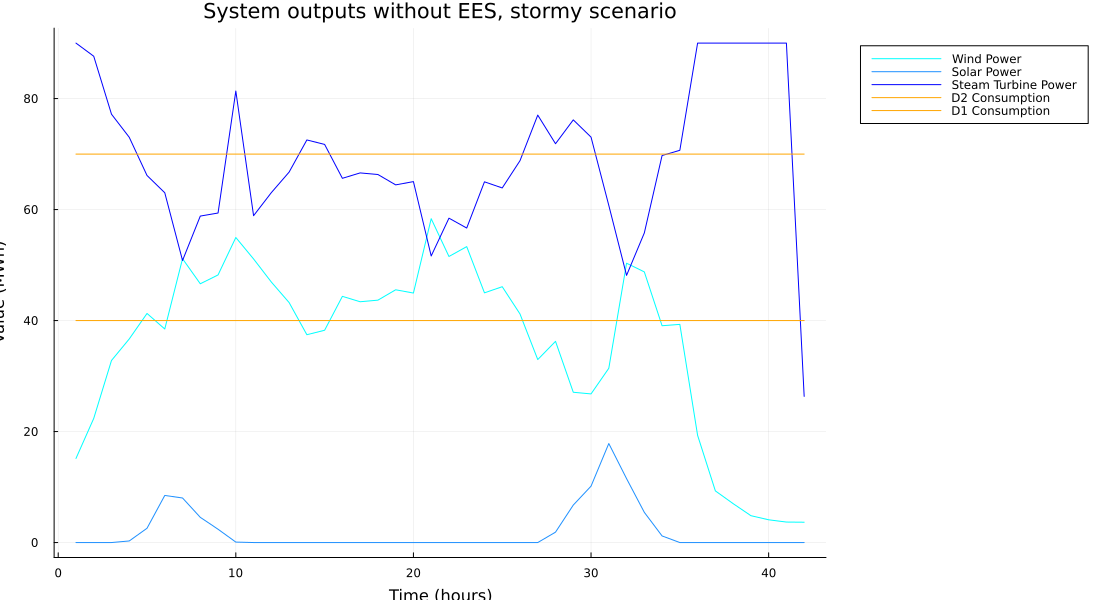

In [23]:
# Visualization of numerical results

p1 = plot(xlabel="Time (hours)", ylabel="Value (MWh)", title="System outputs without EES, stormy scenario", legend=:outertopright, size=(1100, 600), legendfontsize=8)

# Generators (Blue)
colors = [:aqua, :dodgerblue, :blue]
labels = ["Wind Power", "Solar Power", "Steam Turbine Power"]
i = 1
for gen in keys(generators)
    generator_data = [value(pg[gen, t]) for t in 1:42]
    plot!(1:42, generator_data, label=labels[i], color=colors[i])
    i += 1 
end

# Loads (Orange)
for i in keys(loads)
    load_data = [value(pd[i, t]) for t in 1:42]
    plot!(1:42, load_data, label="$i Consumption", color=:orange)
end

# Power Flow on Lines (Yellow)
#for l in keys(lines)
 #   line_data = [value(pf[l, t]) for t in 1:42]
  #  plot!(1:42, line_data, label="$l Power Flow", color=:yellow)
#end

display(p1)

In [24]:
# Model 2, System with EES

m2 = Model(HiGHS.Optimizer)

@variable(m2, 0 <= pg[i in keys(generators), t in 1:42] <= generators[i][:capacity])
@variable(m2, 0 <= pd[i in keys(loads), t in 1:42] <= loads[i][:capacity])

@objective(m2, Max, 
    sum(pd[i, t] * loads[i][:bid] for i in keys(loads), t in 1:42) - 
    sum(pg[i, t] * generators[i][:offer] for i in keys(generators), t in 1:42)
)

# Generator capacity and non-negativity constraints
@constraint(m2, gen_cap[g in keys(generators), t in 1:42], pg[g, t] <= generators[g][:capacity])
@constraint(m2, gen_nonneg[g in keys(generators), t in 1:42], pg[g, t] >= 0)

# Transmission Line Constraints
@variable(m2, δ[b in keys(busses), t in 1:42])
@expression(m2, pf[l in keys(lines), t in 1:42], lines[l][:susceptance] * (δ[lines[l][:from], t] - δ[lines[l][:to], t]))
@constraint(m2, line_cap_pos[l in keys(lines), t in 1:42], pf[l, t] <= lines[l][:capacity])
@constraint(m2, line_cap_neg[l in keys(lines), t in 1:42], pf[l, t] >= -lines[l][:capacity])
@constraint(m2, [t in 1:42], δ[:B1, t] == 0)

# EES variables
ees_capacity = 50.0   # Storage capacity in MWh
ees_pmax = 20.0       # Max charge/discharge power
η_c = 0.95            # Charging efficiency
η_d = 0.9             # Discharging efficiency

@variable(m2, 0 <= soc[t in 1:42] <= ees_capacity)   # EES State of charge
@variable(m2, 0 <= p_ch[t in 1:42] <= ees_pmax)      # EES Charge power
@variable(m2, 0 <= p_dis[t in 1:42] <= ees_pmax)     # EES Discharge power

# Power balance equation
@constraint(m2, λ[b in keys(busses), t in 1:42], 
    sum(pg[g, t] for g in busses[b][:generators]) +
    sum(p_dis[t] for b in keys(busses) if b == :B2) - 
    sum(p_ch[t] for b in keys(busses) if b == :B2) -
    sum(pd[d, t] for d in busses[b][:loads]) - 
    sum(pf[l, t] for l in busses[b][:from]) + 
    sum(pf[l, t] for l in busses[b][:to]) == 0
)

# Scaling renewable energy generators with their respective scenarios
@constraint(m2, [t in 1:42], pg[:G2, t] <= wind_scenario[t] * generators[:G2][:capacity])

@constraint(m2, [t in 1:42], pg[:G3, t] <= solar_scenario[t] * generators[:G3][:capacity])

# SOC evolution constraint
@constraint(m2, soc[1] == 15)  # Battery starts with 15MW
@constraint(m2, [t in 2:42], soc[t] == soc[t-1] + η_c * p_ch[t-1] - (1/η_d) * p_dis[t-1])


# SOC capacity limits
@constraint(m2, [t in 1:42], 0 <= soc[t] <= ees_capacity)

# Binary variables for charge/discharge mode
@variable(m2, y_ch[t in 1:42], Bin)  # 1 if charging
@variable(m2, y_dis[t in 1:42], Bin) # 1 if discharging


# Ensure only one mode is active at any time
@constraint(m2, [t in 1:42], y_ch[t] + y_dis[t] <= 1)


# Link charge/discharge power to binary variables
@constraint(m2, [t in 1:42], p_ch[t] <= y_ch[t] * ees_pmax)
@constraint(m2, [t in 1:42], p_dis[t] <= y_dis[t] * ees_pmax)

# Power balance equation at bus 2 (bus with EES)
@constraint(m2, [t in 1:42], 
    sum(pg[g, t] for g in busses[:B2][:generators]) +
    p_dis[t] - p_ch[t] -
    sum(pd[d, t] for d in busses[:B2][:loads]) - 
    sum(pf[l, t] for l in busses[:B2][:from]) + 
    sum(pf[l, t] for l in busses[:B2][:to]) == 0
)

#print(m2)

optimize!(m2)

sw_m2_stormy = objective_value(m2)

Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [9e-01, 1e+03]
  Cost   [1e+01, 4e+01]
  Bound  [1e+00, 9e+01]
  RHS    [8e-02, 1e+02]
Presolving model
461 rows, 517 cols, 1605 nonzeros  0s
305 rows, 391 cols, 1137 nonzeros  0s
235 rows, 391 cols, 869 nonzeros  0s

Solving MIP model with:
   235 rows
   391 cols (42 binary, 0 integer, 0 implied int., 349 continuous)
   869 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       

141569.68282426777

In [25]:
# Numerical results

println("Social Welfare M2 = ", objective_value(m2)) 
println("")

# Printing generator outputs over time
for i in keys(generators)
    for t in 1:42
        println(i, " at t=", t, " = ", value(pg[i, t]))
    end
end

# Printing load consumption over time
for i in keys(loads)
    for t in 1:42
        println(i, " at t=", t, " = ", value(pd[i, t]))
    end
end

if has_duals(m2)
    for bus in keys(busses)
        for t in 1:42
            println("λ"*string(bus)*" at t=", t, " = ", shadow_price(λ[bus, t]))
        end
    end
else
    println("No dual values")
end

# Printing power flow on lines over time
for l in keys(lines)
    for t in 1:42
        println("pf on "*string(l)*" at t=", t, " = ", value(pf[l, t]))
    end
end

Social Welfare M2 = 141569.68282426777

G2 at t=1 = 15.150999916321732
G2 at t=2 = 22.366436728931955
G2 at t=3 = 32.80919171995676
G2 at t=4 = 36.68855947731275
G2 at t=5 = 41.28105085658173
G2 at t=6 = 38.48167774364109
G2 at t=7 = 51.145864205344246
G2 at t=8 = 46.630872173947196
G2 at t=9 = 48.2253416007093
G2 at t=10 = 54.96846850300326
G2 at t=11 = 51.10182921102515
G2 at t=12 = 46.9432972687416
G2 at t=13 = 43.248579621251814
G2 at t=14 = 37.45212058316833
G2 at t=15 = 38.256323008858374
G2 at t=16 = 44.363992990315126
G2 at t=17 = 43.39221979970868
G2 at t=18 = 43.67898183892744
G2 at t=19 = 45.547877139114654
G2 at t=20 = 44.959358115932986
G2 at t=21 = 58.36021543660478
G2 at t=22 = 51.548681008908716
G2 at t=23 = 53.32679525545407
G2 at t=24 = 44.99801701045191
G2 at t=25 = 46.102681456537454
G2 at t=26 = 41.18968271076275
G2 at t=27 = 32.97408940528372
G2 at t=28 = 36.25760491168379
G2 at t=29 = 27.081500376008456
G2 at t=30 = 26.78409141952821
G2 at t=31 = 31.4029078371820

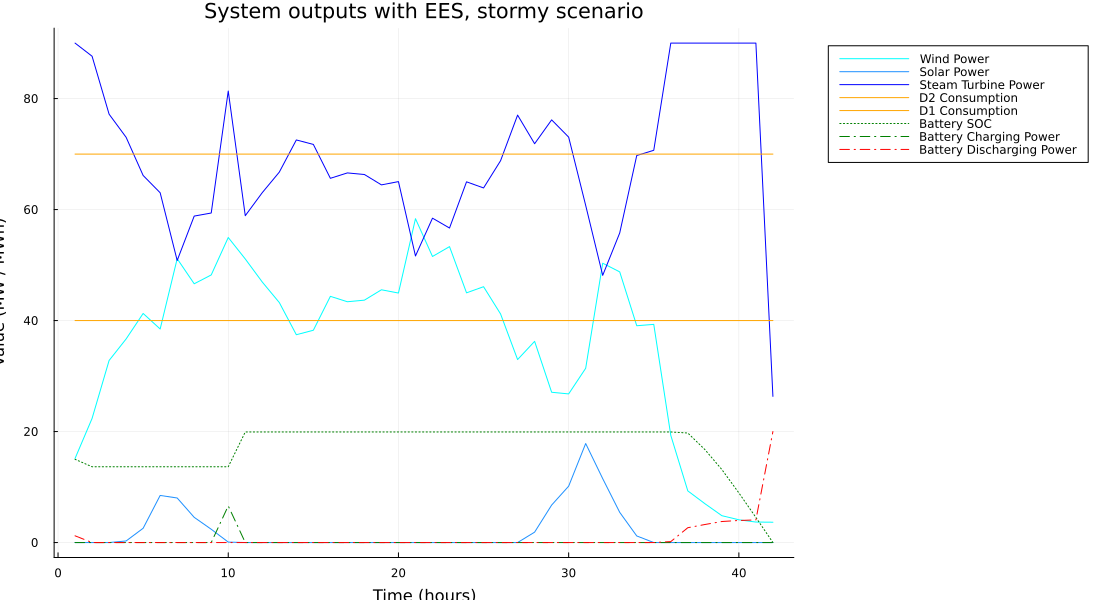

In [26]:
# Visualization of numerical results

p2 = plot(xlabel="Time (hours)", ylabel="Value (MW / MWh)", title="System outputs with EES, stormy scenario", legend=:outertopright, size=(1100, 600), legendfontsize=8)


# Generators (Blue)
colors = [:aqua, :dodgerblue, :blue]
labels = ["Wind Power", "Solar Power", "Steam Turbine Power"]
i = 1
for gen in keys(generators)
    generator_data = [value(pg[gen, t]) for t in 1:42]
    plot!(1:42, generator_data, label=labels[i], color=colors[i])
    i += 1 
end

# Loads (Orange)
for i in keys(loads)
    load_data = [value(pd[i, t]) for t in 1:42]
    plot!(1:42, load_data, label="$i Consumption", color=:orange)
end

# Power Flow on Lines (Yellow)
#for l in keys(lines)
 #   line_data = [value(pf[l, t]) for t in 1:42]
  #  plot!(1:42, line_data, label="$l Power Flow", color=:yellow)
#end

# Battery SOC (Green)
soc_data = [value(soc[t]) for t in 1:42]
plot!(1:42, soc_data, label="Battery SOC", color=:green, linestyle=:dot)

# Battery charging power (green dotted)
p_ch_data = [value(p_ch[t]) for t in 1:42]
plot!(1:42, p_ch_data, label="Battery Charging Power", color=:green, linestyle=:dashdot)

# Battery discharging power (red dotted)
p_dis_data = [value(p_dis[t]) for t in 1:42]
plot!(1:42, p_dis_data, label="Battery Discharging Power", color=:red, linestyle=:dashdot)

display(p2)

# 
############ SECOND SCENARIO : BLUE SKY ##############
#

In [27]:
wind_scenario = OrderedDict(row.time => row.blue_sky for row in eachrow(wind_df))      
solar_scenario = OrderedDict(row.time => row.blue_sky for row in eachrow(solar_df)) 

OrderedDict{Int64, Float64} with 43 entries:
  0  => 0.0
  1  => 0.0
  2  => 0.0
  3  => 0.0
  4  => 0.0129714
  5  => 0.0963427
  6  => 0.232468
  7  => 0.291831
  8  => 0.199326
  9  => 0.0831228
  10 => 0.00390469
  11 => 0.0
  12 => 0.0
  13 => 0.0
  14 => 0.0
  15 => 0.0
  16 => 0.0
  17 => 0.0
  18 => 0.0
  19 => 0.0
  20 => 0.0
  21 => 0.0
  22 => 0.0
  23 => 0.0
  24 => 0.0
  ⋮  => ⋮

In [28]:
# Model 1, System without EES

m1 = Model(HiGHS.Optimizer)

@variable(m1, 0 <= pg[i in keys(generators), t in 1:42] <= generators[i][:capacity])
@variable(m1, 0 <= pd[i in keys(loads), t in 1:42] <= loads[i][:capacity])

@objective(m1, Max, 
    sum(pd[i, t] * loads[i][:bid] for i in keys(loads), t in 1:42) - 
    sum(pg[i, t] * generators[i][:offer] for i in keys(generators), t in 1:42)
)

# Generator capacity and non-negativity constraints
@constraint(m1, gen_cap[g in keys(generators), t in 1:42], pg[g, t] <= generators[g][:capacity])
@constraint(m1, gen_nonneg[g in keys(generators), t in 1:42], pg[g, t] >= 0)

# Transmission line constraints
@variable(m1, δ[b in keys(busses), t in 1:42])
@expression(m1, pf[l in keys(lines), t in 1:42], lines[l][:susceptance] * (δ[lines[l][:from], t] - δ[lines[l][:to], t]))
@constraint(m1, line_cap_pos[l in keys(lines), t in 1:42], pf[l, t] <= lines[l][:capacity])
@constraint(m1, line_cap_neg[l in keys(lines), t in 1:42], pf[l, t] >= -lines[l][:capacity])
@constraint(m1, [t in 1:42], δ[:B1, t] == 0)


# Power balance equation
@constraint(m1, λ[b in keys(busses), t in 1:42], 
    sum(pg[g, t] for g in busses[b][:generators]) -
    sum(pd[d, t] for d in busses[b][:loads]) - 
    sum(pf[l, t] for l in busses[b][:from]) + 
    sum(pf[l, t] for l in busses[b][:to]) == 0
)

# Scaling renewable energy generators with their respective scenarios
@constraint(m1, [t in 1:42], pg[:G2, t] <= wind_scenario[t] * generators[:G2][:capacity])

@constraint(m1, [t in 1:42], pg[:G3, t] <= solar_scenario[t] * generators[:G3][:capacity])

#print(m1) 

optimize!(m1) 

println("")
println("Social Welfare M1 = ", objective_value(m1)) 

sw_m1_bluesky = objective_value(m1)

Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+03]
  Cost   [1e+01, 4e+01]
  Bound  [4e+01, 9e+01]
  RHS    [2e-01, 1e+02]
Presolving model
210 rows, 266 cols, 560 nonzeros  0s
118 rows, 224 cols, 334 nonzeros  0s
42 rows, 182 cols, 182 nonzeros  0s
42 rows, 168 cols, 168 nonzeros  0s
Presolve : Reductions: rows 42(-756); columns 168(-210); elements 168(-1344)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
         42    -1.2634817546e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 42
Objective value     :  1.2634817546e+05
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00

Social Welfare M1 = 126348.1754552895


126348.1754552895

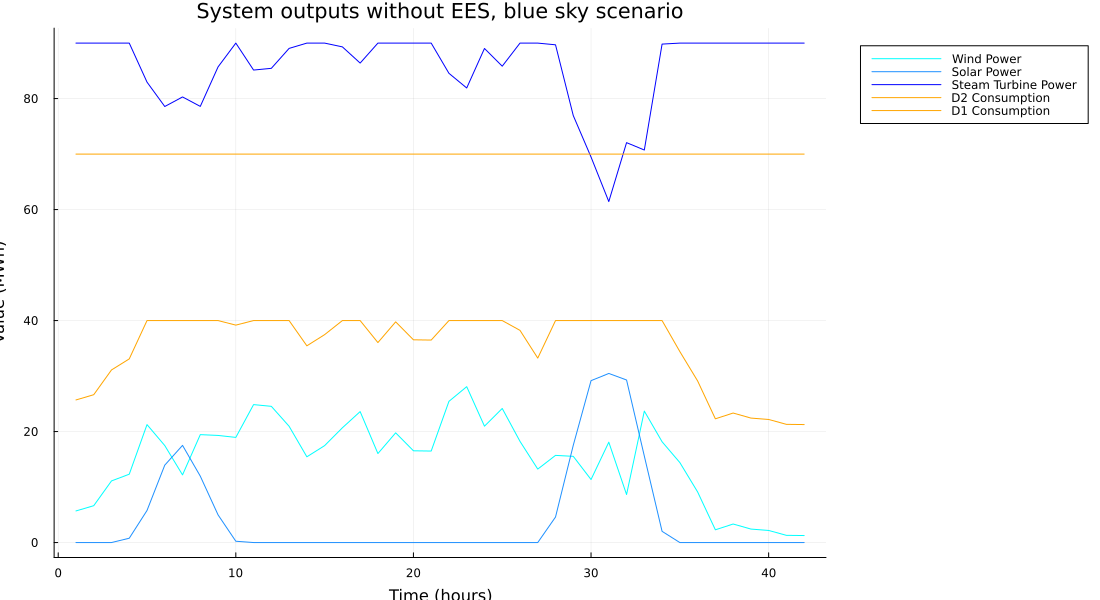

In [30]:
# Visualization

p1 = plot(xlabel="Time (hours)", ylabel="Value (MWh)", title="System outputs without EES, blue sky scenario", legend=:outertopright, size=(1100, 600), legendfontsize=8)

# Generators (Blue)
colors = [:aqua, :dodgerblue, :blue]
labels = ["Wind Power", "Solar Power", "Steam Turbine Power"]
i = 1
for gen in keys(generators)
    generator_data = [value(pg[gen, t]) for t in 1:42]
    plot!(1:42, generator_data, label=labels[i], color=colors[i])
    i += 1 
end

# Loads (Orange)
for i in keys(loads)
    load_data = [value(pd[i, t]) for t in 1:42]
    plot!(1:42, load_data, label="$i Consumption", color=:orange)
end

# Power Flow on Lines (Yellow)
#for l in keys(lines)
#    line_data = [value(pf[l, t]) for t in 1:42]
#    plot!(1:42, line_data, label="$l Power Flow", color=:yellow)
#end

display(p1)

In [31]:
# Model 2, System with EES

m2 = Model(HiGHS.Optimizer)

@variable(m2, 0 <= pg[i in keys(generators), t in 1:42] <= generators[i][:capacity])
@variable(m2, 0 <= pd[i in keys(loads), t in 1:42] <= loads[i][:capacity])

@objective(m2, Max, 
    sum(pd[i, t] * loads[i][:bid] for i in keys(loads), t in 1:42) - 
    sum(pg[i, t] * generators[i][:offer] for i in keys(generators), t in 1:42)
)

# Generator capacity and non-negativity constraints
@constraint(m2, gen_cap[g in keys(generators), t in 1:42], pg[g, t] <= generators[g][:capacity])
@constraint(m2, gen_nonneg[g in keys(generators), t in 1:42], pg[g, t] >= 0)

# Transmission Line Constraints
@variable(m2, δ[b in keys(busses), t in 1:42])
@expression(m2, pf[l in keys(lines), t in 1:42], lines[l][:susceptance] * (δ[lines[l][:from], t] - δ[lines[l][:to], t]))
@constraint(m2, line_cap_pos[l in keys(lines), t in 1:42], pf[l, t] <= lines[l][:capacity])
@constraint(m2, line_cap_neg[l in keys(lines), t in 1:42], pf[l, t] >= -lines[l][:capacity])
@constraint(m2, [t in 1:42], δ[:B1, t] == 0)

# EES variables
ees_capacity = 50.0   # Storage capacity in MWh
ees_pmax = 20.0       # Max charge/discharge power
η_c = 0.95            # Charging efficiency
η_d = 0.9             # Discharging efficiency

@variable(m2, 0 <= soc[t in 1:42] <= ees_capacity)   # EES State of charge
@variable(m2, 0 <= p_ch[t in 1:42] <= ees_pmax)      # EES Charge power
@variable(m2, 0 <= p_dis[t in 1:42] <= ees_pmax)     # EES Discharge power

# Power balance equation
@constraint(m2, λ[b in keys(busses), t in 1:42], 
    sum(pg[g, t] for g in busses[b][:generators]) +
    sum(p_dis[t] for b in keys(busses) if b == :B2) - 
    sum(p_ch[t] for b in keys(busses) if b == :B2) -
    sum(pd[d, t] for d in busses[b][:loads]) - 
    sum(pf[l, t] for l in busses[b][:from]) + 
    sum(pf[l, t] for l in busses[b][:to]) == 0
)

# Scaling renewable energy generators with their respective scenarios
@constraint(m2, [t in 1:42], pg[:G2, t] <= wind_scenario[t] * generators[:G2][:capacity])

@constraint(m2, [t in 1:42], pg[:G3, t] <= solar_scenario[t] * generators[:G3][:capacity])

# SOC evolution constraint
@constraint(m2, soc[1] == 15)  # Battery starts with 15MW
@constraint(m2, [t in 2:42], soc[t] == soc[t-1] + η_c * p_ch[t-1] - (1/η_d) * p_dis[t-1])


# SOC capacity limits
@constraint(m2, [t in 1:42], 0 <= soc[t] <= ees_capacity)

# Binary variables for charge/discharge mode
@variable(m2, y_ch[t in 1:42], Bin)  # 1 if charging
@variable(m2, y_dis[t in 1:42], Bin) # 1 if discharging


# Ensure only one mode is active at any time
@constraint(m2, [t in 1:42], y_ch[t] + y_dis[t] <= 1)


# Link charge/discharge power to binary variables
@constraint(m2, [t in 1:42], p_ch[t] <= y_ch[t] * ees_pmax)
@constraint(m2, [t in 1:42], p_dis[t] <= y_dis[t] * ees_pmax)

# Power balance equation at bus 2 (bus with EES)
@constraint(m2, [t in 1:42], 
    sum(pg[g, t] for g in busses[:B2][:generators]) +
    p_dis[t] - p_ch[t] -
    sum(pd[d, t] for d in busses[:B2][:loads]) - 
    sum(pf[l, t] for l in busses[:B2][:from]) + 
    sum(pf[l, t] for l in busses[:B2][:to]) == 0
)

#print(m2)

optimize!(m2)

println("")
println("Social Welfare M2 = ", objective_value(m2)) 

sw_m2_bluesky = objective_value(m2)

Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [9e-01, 1e+03]
  Cost   [1e+01, 4e+01]
  Bound  [1e+00, 9e+01]
  RHS    [2e-01, 1e+02]
Presolving model
461 rows, 517 cols, 1605 nonzeros  0s
305 rows, 391 cols, 1137 nonzeros  0s
233 rows, 390 cols, 860 nonzeros  0s

Solving MIP model with:
   233 rows
   390 cols (42 binary, 0 integer, 0 implied int., 348 continuous)
   860 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       

132186.82844922825

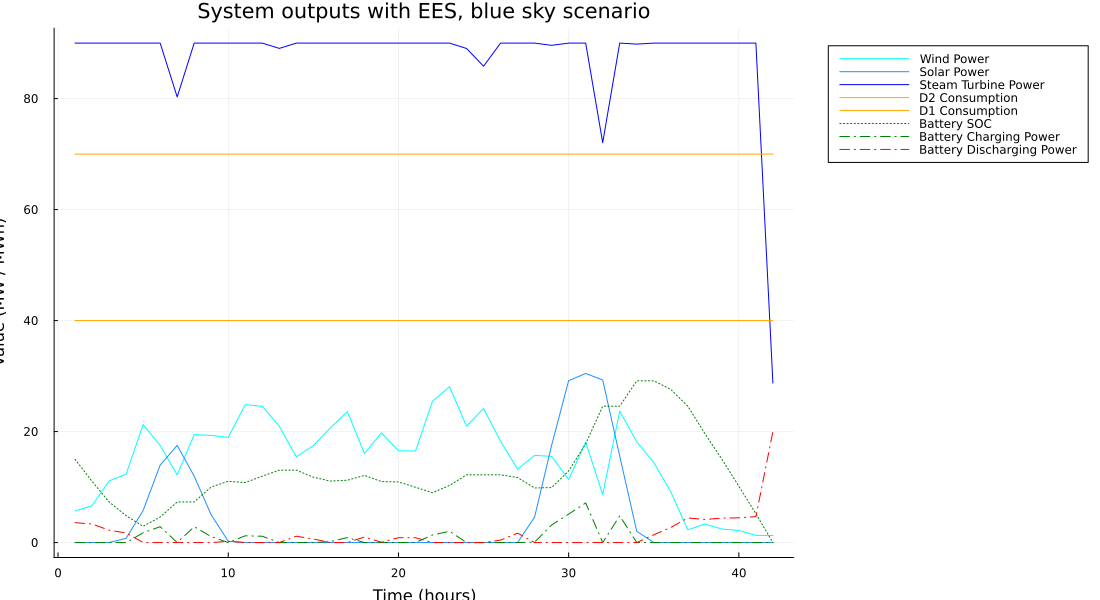

In [32]:
# Visualization

p2 = plot(xlabel="Time (hours)", ylabel="Value (MW / MWh)", title="System outputs with EES, blue sky scenario", legend=:outertopright, size=(1100, 600), legendfontsize=8)

# Generators (Blue)
colors = [:aqua, :dodgerblue, :blue]
labels = ["Wind Power", "Solar Power", "Steam Turbine Power"]
i = 1
for gen in keys(generators)
    generator_data = [value(pg[gen, t]) for t in 1:42]
    plot!(1:42, generator_data, label=labels[i], color=colors[i])
    i += 1 
end

# Loads (Orange)
for i in keys(loads)
    load_data = [value(pd[i, t]) for t in 1:42]
    plot!(1:42, load_data, label="$i Consumption", color=:orange)
end

# Power Flow on Lines (Yellow)
#for l in keys(lines)
#    line_data = [value(pf[l, t]) for t in 1:42]
#    plot!(1:42, line_data, label="$l Power Flow", color=:yellow)
#end

# Battery SOC (Green)
soc_data = [value(soc[t]) for t in 1:42]
plot!(1:42, soc_data, label="Battery SOC", color=:green, linestyle=:dot)

# Battery charging power (green dotted)
p_ch_data = [value(p_ch[t]) for t in 1:42]
plot!(1:42, p_ch_data, label="Battery Charging Power", color=:green, linestyle=:dashdot)

# Battery discharging power (red dotted)
p_dis_data = [value(p_dis[t]) for t in 1:42]
plot!(1:42, p_dis_data, label="Battery Discharging Power", color=:red, linestyle=:dashdot)

display(p2)

# 
############ THIRD SCENARIO : CLOUDY ##############
#

In [33]:
wind_scenario = OrderedDict(row.time => row.cloudy for row in eachrow(wind_df))      
solar_scenario = OrderedDict(row.time => row.cloudy for row in eachrow(solar_df)) 

OrderedDict{Int64, Float64} with 43 entries:
  0  => 0.0
  1  => 0.0
  2  => 0.0
  3  => 0.0
  4  => 0.00707166
  5  => 0.0692697
  6  => 0.164203
  7  => 0.166333
  8  => 0.11891
  9  => 0.0555873
  10 => 0.00184242
  11 => 0.0
  12 => 0.0
  13 => 0.0
  14 => 0.0
  15 => 0.0
  16 => 0.0
  17 => 0.0
  18 => 0.0
  19 => 0.0
  20 => 0.0
  21 => 0.0
  22 => 0.0
  23 => 0.0
  24 => 0.0
  ⋮  => ⋮

In [34]:
# Model 1, System without EES

m1 = Model(HiGHS.Optimizer)

@variable(m1, 0 <= pg[i in keys(generators), t in 1:42] <= generators[i][:capacity])
@variable(m1, 0 <= pd[i in keys(loads), t in 1:42] <= loads[i][:capacity])

@objective(m1, Max, 
    sum(pd[i, t] * loads[i][:bid] for i in keys(loads), t in 1:42) - 
    sum(pg[i, t] * generators[i][:offer] for i in keys(generators), t in 1:42)
)

# Generator capacity and non-negativity constraints
@constraint(m1, gen_cap[g in keys(generators), t in 1:42], pg[g, t] <= generators[g][:capacity])
@constraint(m1, gen_nonneg[g in keys(generators), t in 1:42], pg[g, t] >= 0)

# Transmission line constraints
@variable(m1, δ[b in keys(busses), t in 1:42])
@expression(m1, pf[l in keys(lines), t in 1:42], lines[l][:susceptance] * (δ[lines[l][:from], t] - δ[lines[l][:to], t]))
@constraint(m1, line_cap_pos[l in keys(lines), t in 1:42], pf[l, t] <= lines[l][:capacity])
@constraint(m1, line_cap_neg[l in keys(lines), t in 1:42], pf[l, t] >= -lines[l][:capacity])
@constraint(m1, [t in 1:42], δ[:B1, t] == 0)


# Power balance equation
@constraint(m1, λ[b in keys(busses), t in 1:42], 
    sum(pg[g, t] for g in busses[b][:generators]) -
    sum(pd[d, t] for d in busses[b][:loads]) - 
    sum(pf[l, t] for l in busses[b][:from]) + 
    sum(pf[l, t] for l in busses[b][:to]) == 0
)

# Scaling renewable energy generators with their respective scenarios
@constraint(m1, [t in 1:42], pg[:G2, t] <= wind_scenario[t] * generators[:G2][:capacity])

@constraint(m1, [t in 1:42], pg[:G3, t] <= solar_scenario[t] * generators[:G3][:capacity])

#print(m1) 

optimize!(m1) 

println("")
println("Social Welfare M1 = ", objective_value(m1)) 

sw_m1_cloudy = objective_value(m1)

Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+03]
  Cost   [1e+01, 4e+01]
  Bound  [4e+01, 9e+01]
  RHS    [1e-01, 1e+02]
Presolving model
210 rows, 266 cols, 560 nonzeros  0s
118 rows, 224 cols, 334 nonzeros  0s
42 rows, 182 cols, 182 nonzeros  0s
42 rows, 168 cols, 168 nonzeros  0s
Presolve : Reductions: rows 42(-756); columns 168(-210); elements 168(-1344)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
         42    -1.2999936479e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 42
Objective value     :  1.2999936479e+05
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00

Social Welfare M1 = 129999.36479008968


129999.36479008968

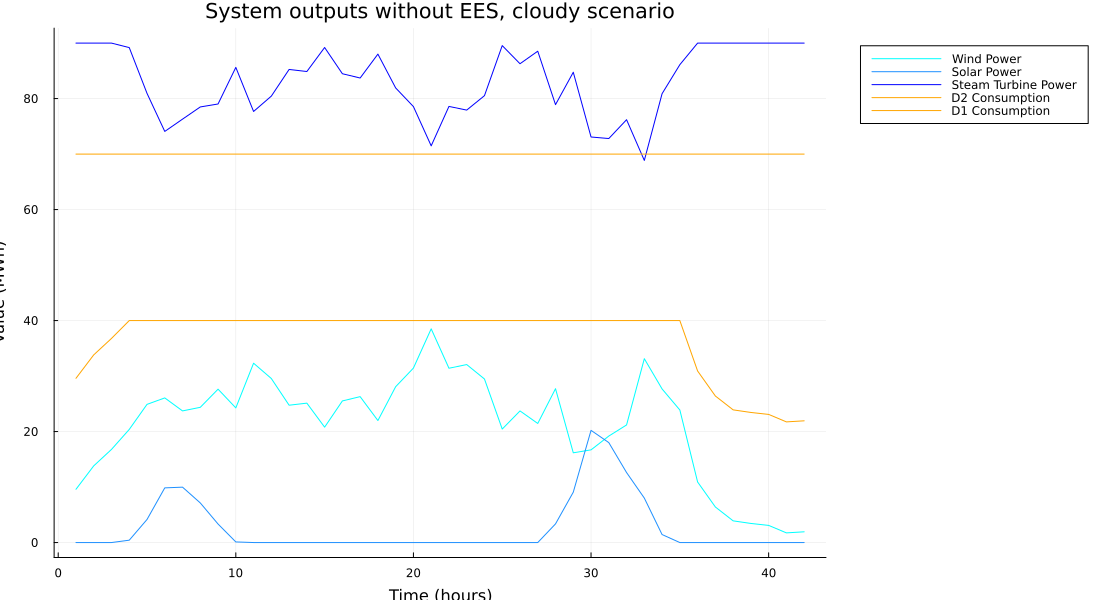

In [36]:
# Visualization

p1 = plot(xlabel="Time (hours)", ylabel="Value (MWh)", title="System outputs without EES, cloudy scenario", legend=:outertopright, size=(1100, 600), legendfontsize=8)

# Generators (Blue)
colors = [:aqua, :dodgerblue, :blue]
labels = ["Wind Power", "Solar Power", "Steam Turbine Power"]
i = 1
for gen in keys(generators)
    generator_data = [value(pg[gen, t]) for t in 1:42]
    plot!(1:42, generator_data, label=labels[i], color=colors[i])
    i += 1 
end

# Loads (Orange)
for i in keys(loads)
    load_data = [value(pd[i, t]) for t in 1:42]
    plot!(1:42, load_data, label="$i Consumption", color=:orange)
end

# Power Flow on Lines (Yellow)
#for l in keys(lines)
#    line_data = [value(pf[l, t]) for t in 1:42]
#    plot!(1:42, line_data, label="$l Power Flow", color=:yellow)
#end

display(p1)

In [37]:
# Model 2, System with EES

m2 = Model(HiGHS.Optimizer)

@variable(m2, 0 <= pg[i in keys(generators), t in 1:42] <= generators[i][:capacity])
@variable(m2, 0 <= pd[i in keys(loads), t in 1:42] <= loads[i][:capacity])

@objective(m2, Max, 
    sum(pd[i, t] * loads[i][:bid] for i in keys(loads), t in 1:42) - 
    sum(pg[i, t] * generators[i][:offer] for i in keys(generators), t in 1:42)
)

# Generator capacity and non-negativity constraints
@constraint(m2, gen_cap[g in keys(generators), t in 1:42], pg[g, t] <= generators[g][:capacity])
@constraint(m2, gen_nonneg[g in keys(generators), t in 1:42], pg[g, t] >= 0)

# Transmission Line Constraints
@variable(m2, δ[b in keys(busses), t in 1:42])
@expression(m2, pf[l in keys(lines), t in 1:42], lines[l][:susceptance] * (δ[lines[l][:from], t] - δ[lines[l][:to], t]))
@constraint(m2, line_cap_pos[l in keys(lines), t in 1:42], pf[l, t] <= lines[l][:capacity])
@constraint(m2, line_cap_neg[l in keys(lines), t in 1:42], pf[l, t] >= -lines[l][:capacity])
@constraint(m2, [t in 1:42], δ[:B1, t] == 0)

# EES variables
ees_capacity = 50.0   # Storage capacity in MWh
ees_pmax = 20.0       # Max charge/discharge power
η_c = 0.95            # Charging efficiency
η_d = 0.9             # Discharging efficiency

@variable(m2, 0 <= soc[t in 1:42] <= ees_capacity)   # EES State of charge
@variable(m2, 0 <= p_ch[t in 1:42] <= ees_pmax)      # EES Charge power
@variable(m2, 0 <= p_dis[t in 1:42] <= ees_pmax)     # EES Discharge power

# Power balance equation
@constraint(m2, λ[b in keys(busses), t in 1:42], 
    sum(pg[g, t] for g in busses[b][:generators]) +
    sum(p_dis[t] for b in keys(busses) if b == :B2) - 
    sum(p_ch[t] for b in keys(busses) if b == :B2) -
    sum(pd[d, t] for d in busses[b][:loads]) - 
    sum(pf[l, t] for l in busses[b][:from]) + 
    sum(pf[l, t] for l in busses[b][:to]) == 0
)

# Scaling renewable energy generators with their respective scenarios
@constraint(m2, [t in 1:42], pg[:G2, t] <= wind_scenario[t] * generators[:G2][:capacity])

@constraint(m2, [t in 1:42], pg[:G3, t] <= solar_scenario[t] * generators[:G3][:capacity])

# SOC evolution constraint
@constraint(m2, soc[1] == 15)  # Battery starts with 15MW
@constraint(m2, [t in 2:42], soc[t] == soc[t-1] + η_c * p_ch[t-1] - (1/η_d) * p_dis[t-1])


# SOC capacity limits
@constraint(m2, [t in 1:42], 0 <= soc[t] <= ees_capacity)

# Binary variables for charge/discharge mode
@variable(m2, y_ch[t in 1:42], Bin)  # 1 if charging
@variable(m2, y_dis[t in 1:42], Bin) # 1 if discharging


# Ensure only one mode is active at any time
@constraint(m2, [t in 1:42], y_ch[t] + y_dis[t] <= 1)


# Link charge/discharge power to binary variables
@constraint(m2, [t in 1:42], p_ch[t] <= y_ch[t] * ees_pmax)
@constraint(m2, [t in 1:42], p_dis[t] <= y_dis[t] * ees_pmax)

# Power balance equation at bus 2 (bus with EES)
@constraint(m2, [t in 1:42], 
    sum(pg[g, t] for g in busses[:B2][:generators]) +
    p_dis[t] - p_ch[t] -
    sum(pd[d, t] for d in busses[:B2][:loads]) - 
    sum(pf[l, t] for l in busses[:B2][:from]) + 
    sum(pf[l, t] for l in busses[:B2][:to]) == 0
)

#print(m2)

optimize!(m2)

println("")
println("Social Welfare M2 = ", objective_value(m2)) 

sw_m2_cloudy = objective_value(m2)

Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [9e-01, 1e+03]
  Cost   [1e+01, 4e+01]
  Bound  [1e+00, 9e+01]
  RHS    [1e-01, 1e+02]
Presolving model
461 rows, 517 cols, 1605 nonzeros  0s
305 rows, 391 cols, 1137 nonzeros  0s
235 rows, 391 cols, 869 nonzeros  0s

Solving MIP model with:
   235 rows
   391 cols (42 binary, 0 integer, 0 implied int., 349 continuous)
   869 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       

134445.13603716204

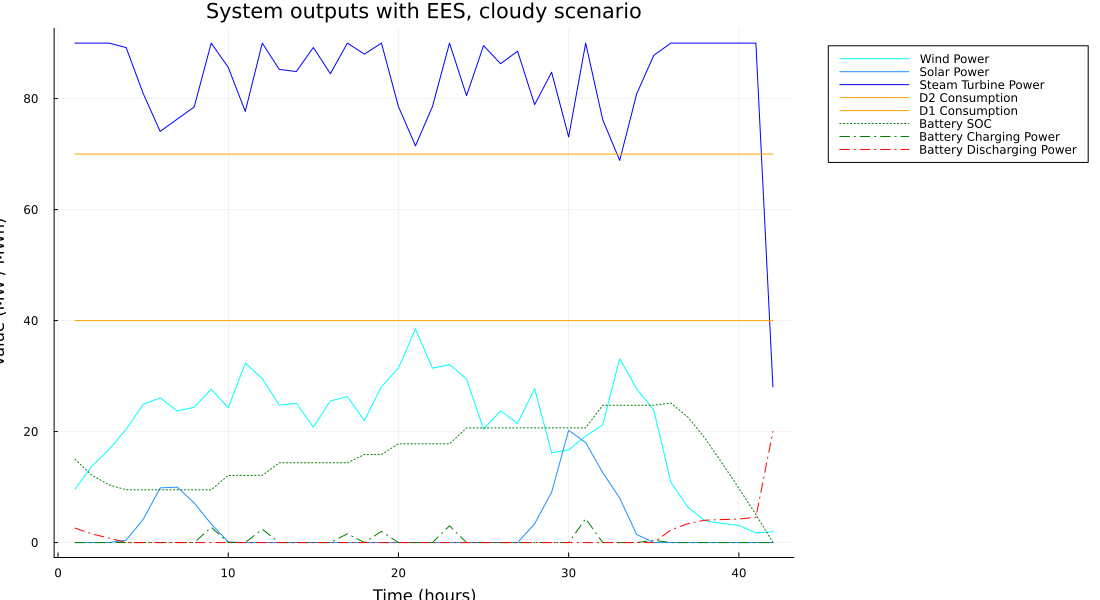

In [38]:
# Visualization

p2 = plot(xlabel="Time (hours)", ylabel="Value (MW / MWh)", title="System outputs with EES, cloudy scenario", legend=:outertopright, size=(1100, 600), legendfontsize=8)

# Generators (Blue)
colors = [:aqua, :dodgerblue, :blue]
labels = ["Wind Power", "Solar Power", "Steam Turbine Power"]
i = 1
for gen in keys(generators)
    generator_data = [value(pg[gen, t]) for t in 1:42]
    plot!(1:42, generator_data, label=labels[i], color=colors[i])
    i += 1 
end

# Loads (Orange)
for i in keys(loads)
    load_data = [value(pd[i, t]) for t in 1:42]
    plot!(1:42, load_data, label="$i Consumption", color=:orange)
end

# Power Flow on Lines (Yellow)
#for l in keys(lines)
#    line_data = [value(pf[l, t]) for t in 1:42]
#    plot!(1:42, line_data, label="$l Power Flow", color=:yellow)
#end

# Battery SOC (Green)
soc_data = [value(soc[t]) for t in 1:42]
plot!(1:42, soc_data, label="Battery SOC", color=:green, linestyle=:dot)

# Battery charging power (green dotted)
p_ch_data = [value(p_ch[t]) for t in 1:42]
plot!(1:42, p_ch_data, label="Battery Charging Power", color=:green, linestyle=:dashdot)

# Battery discharging power (red dotted)
p_dis_data = [value(p_dis[t]) for t in 1:42]
plot!(1:42, p_dis_data, label="Battery Discharging Power", color=:red, linestyle=:dashdot)

display(p2)

In [39]:
println("Social Welfare Comparison")
println("")
println("Scenario 1: Stormy")
println("")
println("Without EES: ", sw_m1_stormy)
println("With EES: ", sw_m2_stormy)
println("% Increase: +", (sw_m2_stormy/sw_m1_stormy)*100-100, "%")
println("")
println("Scenario 2: Blue Sky")
println("")
println("Without EES: ", sw_m1_bluesky)
println("With EES: ", sw_m2_bluesky)
println("% Increase: +", (sw_m2_bluesky/sw_m1_bluesky)*100-100, "%")
println("")
println("Scenario 3: Cloudy")
println("")
println("Without EES: ", sw_m1_cloudy)
println("With EES: ", sw_m2_cloudy)
println("% Increase: +", (sw_m2_cloudy/sw_m1_cloudy)*100-100, "%")
println("")
println("Average % Increase: +", ((((sw_m2_stormy/sw_m1_stormy)*100-100) + ((sw_m2_bluesky/sw_m1_bluesky)*100-100) + ((sw_m2_cloudy/sw_m1_cloudy)*100-100))/3), "%")

Social Welfare Comparison

Scenario 1: Stormy

Without EES: 137870.4837394426
With EES: 141569.68282426777
% Increase: +2.6830971970883724%

Scenario 2: Blue Sky

Without EES: 126348.1754552895
With EES: 132186.82844922825
% Increase: +4.621082158803986%

Scenario 3: Cloudy

Without EES: 129999.36479008968
With EES: 134445.13603716204
% Increase: +3.419840746338238%

Average % Increase: +3.574673367410199%
